# Deep Learning Class Project
Jinghong(David) He

The goal of this project is to develop a recommendation system to generate alternative healthcare providers. The recommender system will utilize machine learning algorithms such as Cosine Similarity, Euclidean Distance, Jaccard Similarity, and Factorization Machine, to provide accurate, personalized recommendations.

This project will have two general use cases:

1) When the top choice provider(assuming we already know) is not available, provide alternative solution

2) Fill in the patient's specific need(s) and generate recommendation based on his/her needs

Source: https://www.kaggle.com/datasets/tamilsel/healthcare-providers-data?datasetId=860208

In [1]:
# Load Necessary Packages
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import jaccard_score
from lightfm import LightFM
from scipy import sparse
from scipy.sparse import coo_matrix
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
import folium
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")      

/Users/jinghonghe/opt/anaconda3/envs/New/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## 1. Exploratary Data Analysis

### a) Load & Preview Data

In [2]:
# Load Data
df = pd.read_csv('Healthcare Providers.csv')

In [3]:
# save data 
df_raw = df.copy()

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)

In [5]:
df

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,SAINT LOUIS,631041004.0,MO,US,Internal Medicine,Y,F,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,FAYETTEVILLE,283043815.0,NC,US,Obstetrics & Gynecology,Y,O,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,NORTH HAVEN,64732343.0,CT,US,Podiatry,Y,O,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,KANSAS CITY,641183998.0,MO,US,Internal Medicine,Y,O,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,JUPITER,334585700.0,FL,US,Internal Medicine,Y,O,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3837311,1386938868,PAPES,JOAN,NaN,PT,F,I,324 E BALTIMORE ST,NaN,WILMINGTON,604811236.0,IL,US,Physical Therapist in Private Practice,Y,O,97162,"Evaluation of physical therapy, typically 30 m...",N,20,20,20,85.3725,214,60.7255,62.2485
99996,2079360,1215091327,HAYNER,MARGARET,S,ARNP,F,I,645 NW 4TH ST,NaN,REDMOND,977561502.0,OR,US,Nurse Practitioner,Y,O,99213,Established patient office or other outpatient...,N,136,107,136,61.27,144.05147059,30.006176471,37.040220588
99997,8927965,1902868185,VALENCIA,DANA,NaN,M.D.,M,I,3009 N BALLAS RD,SUITE 202B,SAINT LOUIS,631312322.0,MO,US,Cardiology,Y,F,93320,"Doppler ultrasound study of heart blood flow, ...",N,11,11,11,17.98,109.54545455,14.09,14.62
99998,8854571,1891941183,GONZALEZ-LAMOS,RAFAELA,NaN,NaN,F,I,2365 BOSTON POST RD,SUITE 201,LARCHMONT,105383500.0,NY,US,Internal Medicine,Y,O,G0008,Administration of influenza virus vaccine,N,12,12,12,30.54,65,29.93,25.32


### b) Understand the Feature and Values

In [6]:
for x in df.columns:
    print('-----COLUMNS-----', x)
    print(df[x].dtype)
    print(df[x].unique().tolist()[:20])

-----COLUMNS----- index
int64
[8774979, 3354385, 3001884, 7594822, 746159, 3443985, 2137027, 6169160, 5086226, 3900718, 2029507, 7138229, 8575214, 9280862, 1853428, 6682029, 3642669, 7008969, 7900276, 8381319]
-----COLUMNS----- National Provider Identifier
int64
[1891106191, 1346202256, 1306820956, 1770523540, 1073627758, 1346571551, 1215943535, 1629160551, 1518929124, 1396781134, 1205869104, 1720086507, 1871511741, 1942246814, 1184886806, 1679737241, 1366846719, 1710088190, 1801136759, 1851322572]
-----COLUMNS----- Last Name/Organization Name of the Provider
object
['UPADHYAYULA', 'JONES', 'DUROCHER', 'FULLARD', 'PERROTTI', 'PUGH', 'BRUMITT', 'GALBREATH', 'BOONE', 'METWEST INC', 'ROSEN', 'RODRIGUEZ', 'MADUPUR', 'SARANI', 'BHATIA', 'HENKEL', 'ORREGO', 'CAMPBELL', 'BERNARDO', 'SHAPIRO']
-----COLUMNS----- First Name of the Provider
object
['SATYASREE', 'WENDY', 'RICHARD', 'JASPER', 'ANTHONY', 'JOHN', 'TOM', 'RONALD', 'RALPH', nan, 'LAUREN', 'ERIC', 'MUKESH', 'BABAK', 'GAURAV', 'AMY', 'MA

### c) Explore and Identify Preprocessing Steps

In [7]:
# Count of missing value per column
df.isnull().sum()

index                                                           0
National Provider Identifier                                    0
Last Name/Organization Name of the Provider                     0
First Name of the Provider                                   4255
Middle Initial of the Provider                              29331
Credentials of the Provider                                  7209
Gender of the Provider                                       4254
Entity Type of the Provider                                     0
Street Address 1 of the Provider                                0
Street Address 2 of the Provider                            59363
City of the Provider                                            0
Zip Code of the Provider                                        0
State Code of the Provider                                      0
Country Code of the Provider                                    0
Provider Type                                                   0
Medicare P

In [8]:
# Count of missing value by percentage per column 
for col in df.columns:
    null_val = df[col].isnull().sum()
    null_prec = (null_val * 100) / df.shape[0]
    print('> %s , Missing: %d (%.1f%%)' % (col, null_val, null_prec))

> index , Missing: 0 (0.0%)
> National Provider Identifier , Missing: 0 (0.0%)
> Last Name/Organization Name of the Provider , Missing: 0 (0.0%)
> First Name of the Provider , Missing: 4255 (4.3%)
> Middle Initial of the Provider , Missing: 29331 (29.3%)
> Credentials of the Provider , Missing: 7209 (7.2%)
> Gender of the Provider , Missing: 4254 (4.3%)
> Entity Type of the Provider , Missing: 0 (0.0%)
> Street Address 1 of the Provider , Missing: 0 (0.0%)
> Street Address 2 of the Provider , Missing: 59363 (59.4%)
> City of the Provider , Missing: 0 (0.0%)
> Zip Code of the Provider , Missing: 0 (0.0%)
> State Code of the Provider , Missing: 0 (0.0%)
> Country Code of the Provider , Missing: 0 (0.0%)
> Provider Type , Missing: 0 (0.0%)
> Medicare Participation Indicator , Missing: 0 (0.0%)
> Place of Service , Missing: 0 (0.0%)
> HCPCS Code , Missing: 0 (0.0%)
> HCPCS Description , Missing: 0 (0.0%)
> HCPCS Drug Indicator , Missing: 0 (0.0%)
> Number of Services , Missing: 0 (0.0%)
> 

In [9]:
# Count of missing value per row
missing_value_row = pd.DataFrame(df.isnull().sum(axis=1))
missing_value_row[0].value_counts()

1    49980
0    29346
2    15175
5     3331
3     1245
4      923
Name: 0, dtype: int64

In [10]:
# Examine the row that has way too many missing value
missing_value_row[missing_value_row[0] == 4]

,0
93,4
287,4
321,4
329,4
340,4
...,...
99138,4
99463,4
99667,4
99774,4


In [11]:
df[93:]

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
93,5785448,1588757033,ENIGMA MANAGEMENT CORP,NaN,NaN,NaN,NaN,O,3611 14TH AVE,STE 220,BROOKLYN,112183750.0,NY,US,Clinical Laboratory,Y,O,86334,Immunologic analysis technique on serum,N,26,25,26,30.65,482.19,30.04,30.04
94,4186829,1427099936,ROFFE,MARCOS,NaN,M.D.,M,I,12500 WILLOWBROOK RD,NaN,CUMBERLAND,215026393.0,MD,US,Diagnostic Radiology,Y,F,93979,"Ultrasound scan of blood flow of aorta, vena c...",N,15,15,15,25.94,88,20.33,18.57
95,781172,1073896577,MCLEOD,KARIN,E,P.A.-C,F,I,24 FRANK LLOYD WRIGHT DR,NaN,ANN ARBOR,481059484.0,MI,US,Physician Assistant,Y,O,99213,Established patient office or other outpatient...,N,24,23,24,44.92,57,35.22,34.44
96,2553682,1255711347,RODRIGUEZ,CARLOS,A,PHD,M,I,2750 E BELTLINE AVE NE,NaN,GRAND RAPIDS,495258614.0,MI,US,"Psychologist, Clinical",Y,O,96119,Neuropsychological testing by technician with ...,N,20,11,11,75.59,154,59.2605,63.0245
97,7916551,1801816038,TESSLER,FRANKLIN,N,MD,M,I,619 19TH STREET SOUTH,NaN,BIRMINGHAM,35233.0,AL,US,Diagnostic Radiology,Y,F,76776,Ultrasound of transplanted kidney,N,35,35,35,36.622,179,28.712,29.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3837311,1386938868,PAPES,JOAN,NaN,PT,F,I,324 E BALTIMORE ST,NaN,WILMINGTON,604811236.0,IL,US,Physical Therapist in Private Practice,Y,O,97162,"Evaluation of physical therapy, typically 30 m...",N,20,20,20,85.3725,214,60.7255,62.2485
99996,2079360,1215091327,HAYNER,MARGARET,S,ARNP,F,I,645 NW 4TH ST,NaN,REDMOND,977561502.0,OR,US,Nurse Practitioner,Y,O,99213,Established patient office or other outpatient...,N,136,107,136,61.27,144.05147059,30.006176471,37.040220588
99997,8927965,1902868185,VALENCIA,DANA,NaN,M.D.,M,I,3009 N BALLAS RD,SUITE 202B,SAINT LOUIS,631312322.0,MO,US,Cardiology,Y,F,93320,"Doppler ultrasound study of heart blood flow, ...",N,11,11,11,17.98,109.54545455,14.09,14.62
99998,8854571,1891941183,GONZALEZ-LAMOS,RAFAELA,NaN,NaN,F,I,2365 BOSTON POST RD,SUITE 201,LARCHMONT,105383500.0,NY,US,Internal Medicine,Y,O,G0008,Administration of influenza virus vaccine,N,12,12,12,30.54,65,29.93,25.32


### d) Display Raw Data

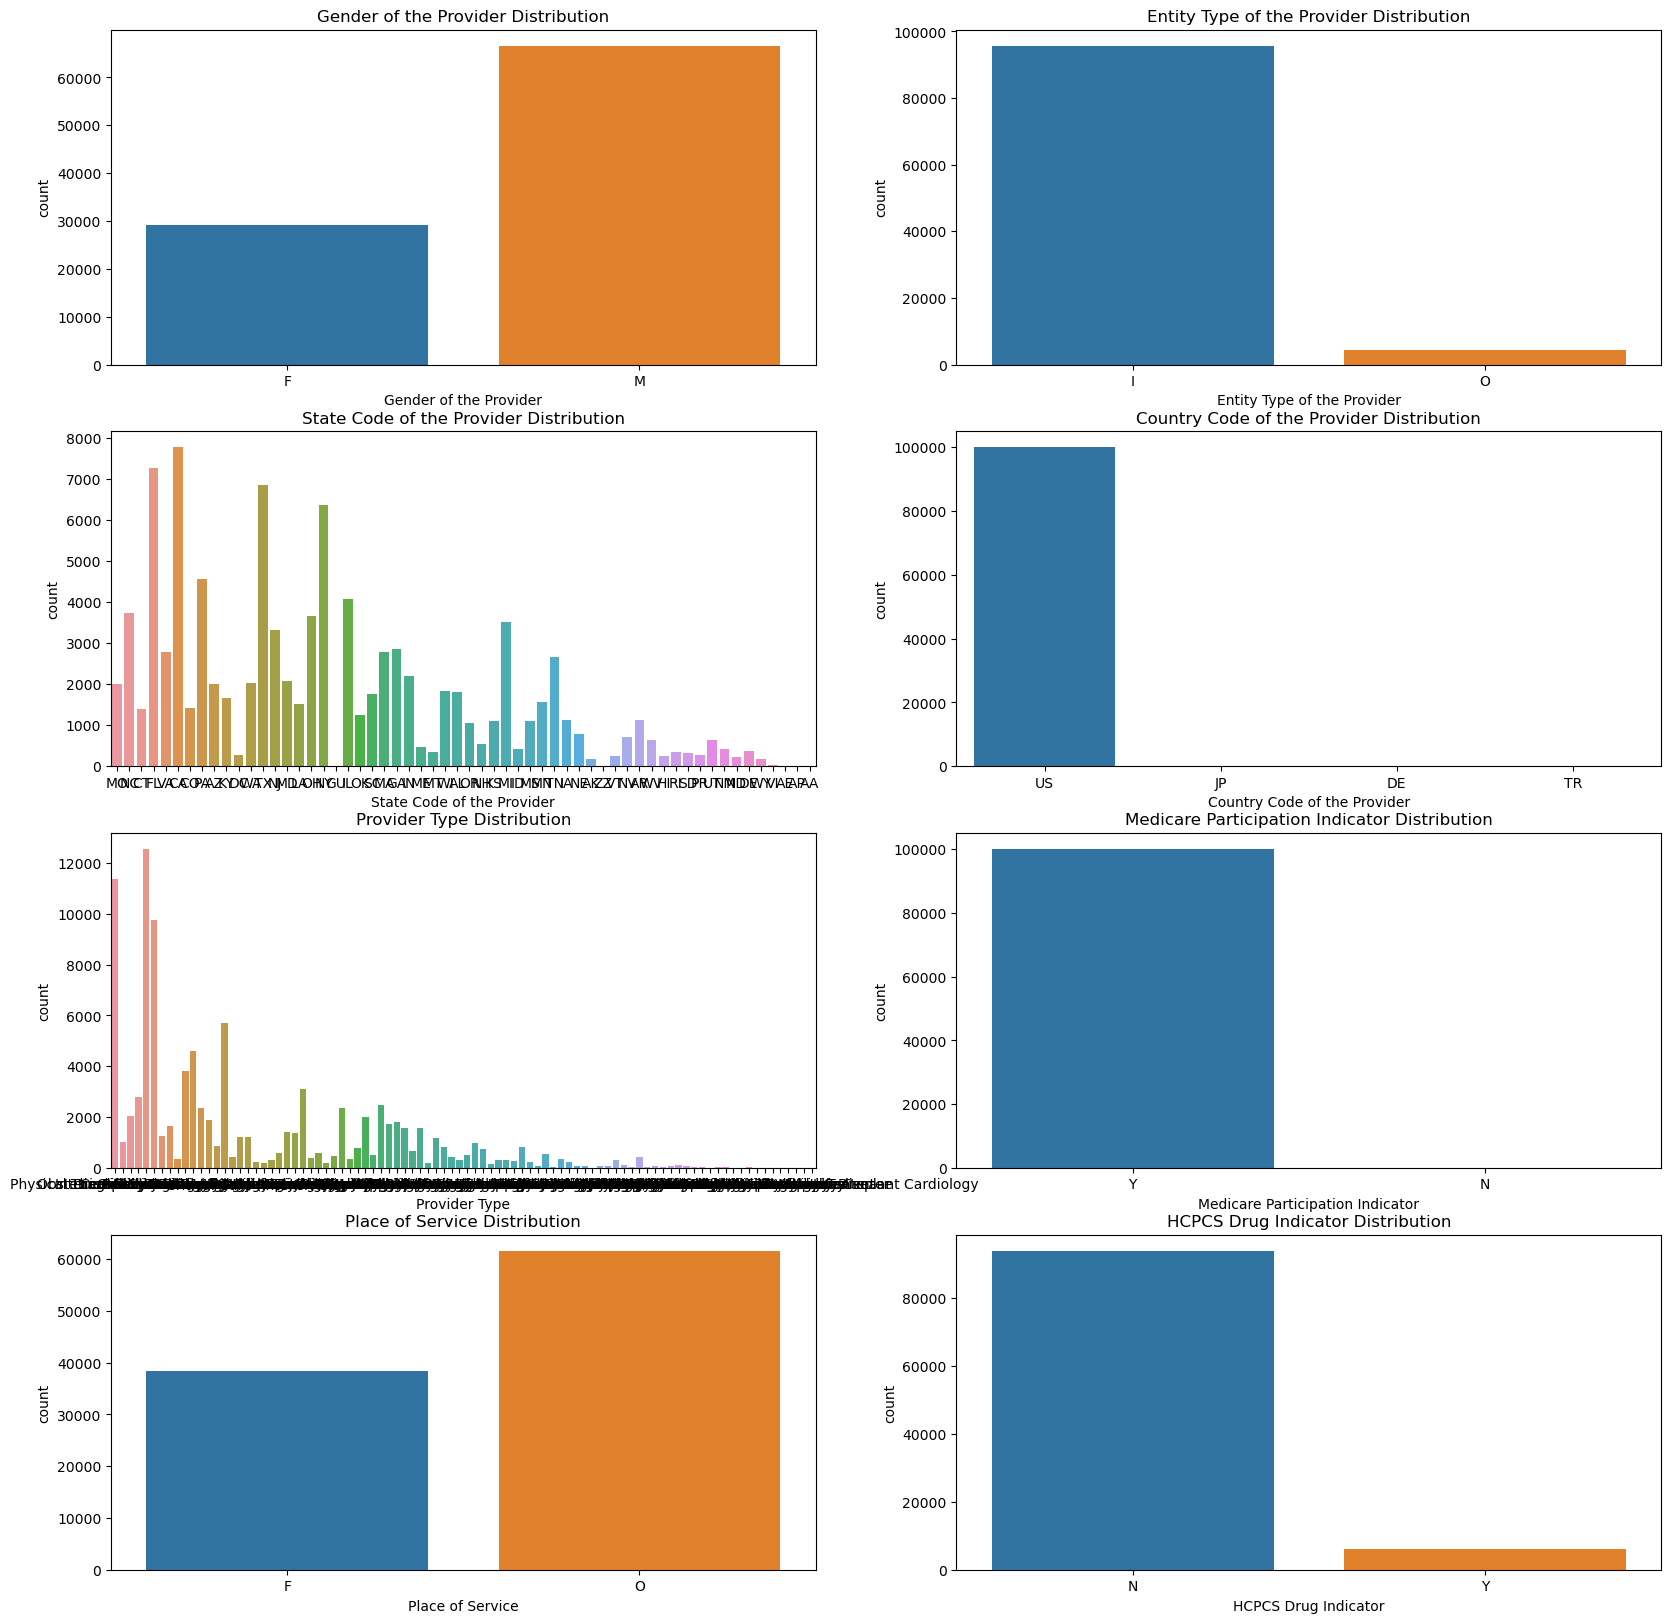

In [12]:
plt.figure(figsize=[20,20])
col = ['Gender of the Provider','Entity Type of the Provider',
      'State Code of the Provider','Country Code of the Provider','Provider Type','Medicare Participation Indicator',
      'Place of Service','HCPCS Drug Indicator']

n=1
for col_name in col:
    plt.subplot(4,2,n)
    sns.countplot(x=col_name,data=df)
    plt.title(f"{col_name} Distribution") 
    n=n+1
    
plt.show()

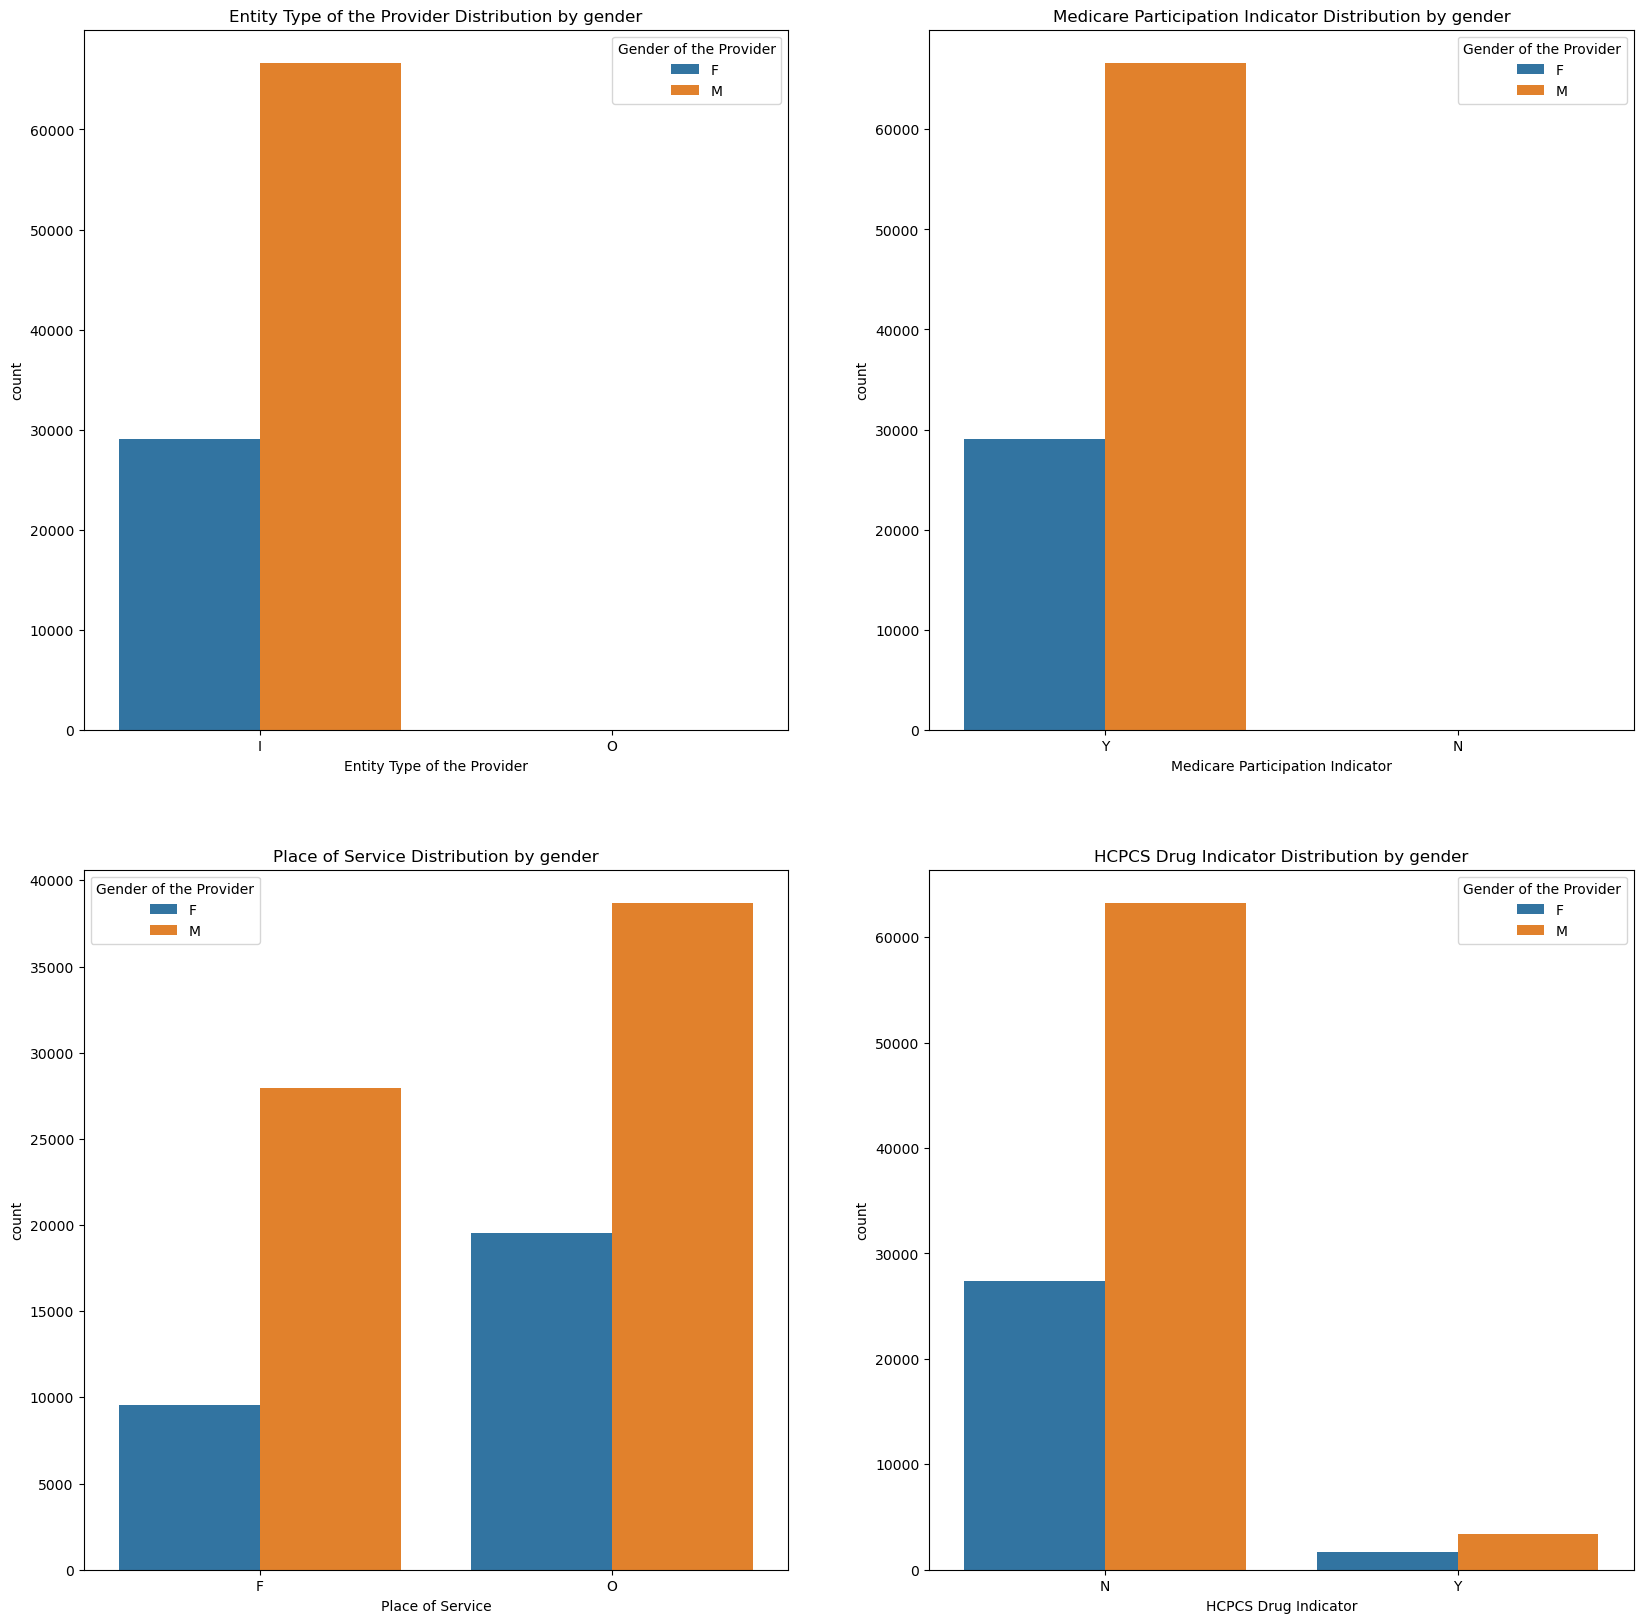

In [13]:
plt.figure(figsize=[20,20])
col = ['Entity Type of the Provider','Medicare Participation Indicator',
      'Place of Service','HCPCS Drug Indicator']

n=1
for col_name in col:
    plt.subplot(2,2,n)
    sns.countplot(x=col_name,data=df, hue='Gender of the Provider')
    plt.title(f"{col_name} Distribution by gender") 
    n=n+1
    
plt.show()

In [14]:
df

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,SAINT LOUIS,631041004.0,MO,US,Internal Medicine,Y,F,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,FAYETTEVILLE,283043815.0,NC,US,Obstetrics & Gynecology,Y,O,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,NORTH HAVEN,64732343.0,CT,US,Podiatry,Y,O,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,KANSAS CITY,641183998.0,MO,US,Internal Medicine,Y,O,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,JUPITER,334585700.0,FL,US,Internal Medicine,Y,O,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3837311,1386938868,PAPES,JOAN,NaN,PT,F,I,324 E BALTIMORE ST,NaN,WILMINGTON,604811236.0,IL,US,Physical Therapist in Private Practice,Y,O,97162,"Evaluation of physical therapy, typically 30 m...",N,20,20,20,85.3725,214,60.7255,62.2485
99996,2079360,1215091327,HAYNER,MARGARET,S,ARNP,F,I,645 NW 4TH ST,NaN,REDMOND,977561502.0,OR,US,Nurse Practitioner,Y,O,99213,Established patient office or other outpatient...,N,136,107,136,61.27,144.05147059,30.006176471,37.040220588
99997,8927965,1902868185,VALENCIA,DANA,NaN,M.D.,M,I,3009 N BALLAS RD,SUITE 202B,SAINT LOUIS,631312322.0,MO,US,Cardiology,Y,F,93320,"Doppler ultrasound study of heart blood flow, ...",N,11,11,11,17.98,109.54545455,14.09,14.62
99998,8854571,1891941183,GONZALEZ-LAMOS,RAFAELA,NaN,NaN,F,I,2365 BOSTON POST RD,SUITE 201,LARCHMONT,105383500.0,NY,US,Internal Medicine,Y,O,G0008,Administration of influenza virus vaccine,N,12,12,12,30.54,65,29.93,25.32


## 2. Feature Engineering 

### a) index
drop the column, assuming index is autogenerated

In [15]:
df = df.loc[:, df.columns != 'index']

### b) National Provider Identifier

In [16]:
df['National Provider Identifier'].min()

1003001298

In [17]:
df['National Provider Identifier'].max()

1992999874

No absurd value found. Drop the column.

In [18]:
df = df.loc[:, df.columns != 'National Provider Identifier']

### c) Last Name/Organization Name of the Provider, First Name of the Provider, Middle Initial of the Provider 
Drop all columns associated with names

In [19]:
df = df.loc[:, df.columns != 'Last Name/Organization Name of the Provider']

In [20]:
df = df.loc[:, df.columns != 'First Name of the Provider']

In [21]:
df = df.loc[:, df.columns != 'Middle Initial of the Provider']

### d) Credentials of the Provider

In [22]:
df['Credentials of the Provider'].nunique()

1854

In [23]:
df['Credentials of the Provider'].isnull().sum()

7209

In [24]:
df['Credentials of the Provider'].fillna('Unknown', inplace=True)

In [25]:
df = df.loc[:, df.columns != 'Credentials of the Provider']

Removed because less important. Assume all providers are credible.

### e) Gender of the Provider

In [26]:
df['Gender of the Provider'].fillna('Other' ,inplace=True)

In [27]:
# One - Hot encoding 
gender_ohe = pd.get_dummies(df['Gender of the Provider'], prefix='gender')

#merge one-hot encoded columns back with original DataFrame
df = df.loc[:, df.columns != 'Gender of the Provider'].join(gender_ohe)

### f) Entity Type of the Provider
For the nature of this project, remove all organization listed, then drop the column

In [28]:
df = df.drop(df[df['Entity Type of the Provider'] == 'O'].index)

In [29]:
df = df.loc[:, df.columns != 'Entity Type of the Provider']

### g) Street Address 1 of the Provider, Street Address 2 of the Provider

Drop these columns for Address as it is less relevant in this

In [30]:
df = df.loc[:, df.columns != 'Street Address 1 of the Provider']

In [31]:
df = df.loc[:, df.columns != 'Street Address 2 of the Provider']

### h) City of the Provider, Zip Code of the Provider, State Code of the Provider

These information are useful in a non-machine learning way. The results could potentially be filtered on distance by useing these conditions. Liscenses are also state based so as a matter of fact these conditions should be hard coded to filter on our recommender system result.

In [32]:
df = df.loc[:, df.columns != 'City of the Provider']

In [33]:
df = df.loc[:, df.columns != 'Zip Code of the Provider']

For computational similicity issue, keep only provdiers in IL in this case.

In [34]:
df = df.loc[df['State Code of the Provider'] == 'IL']

In [35]:
df = df.loc[:, df.columns != 'State Code of the Provider']

### i) Country Code of the Provider
Keep to US locations only then drop the column

In [36]:
df = df.loc[df['Country Code of the Provider'] == 'US']

In [37]:
df = df.loc[:, df.columns != 'Country Code of the Provider']

### j) Provider Type

In [38]:
df['Provider Type'].nunique()

63

In [39]:
# One - Hot encoding 
provider_type_ohe = pd.get_dummies(df['Provider Type'], prefix='type')

#merge one-hot encoded columns back with original DataFrame
df = df.loc[:, df.columns != 'Provider Type'].join(provider_type_ohe)

### k) Medicare Participation Indicator

In [40]:
df['Medicare Participation Indicator'].value_counts(normalize=True) * 100

Y    99.897855
N     0.102145
Name: Medicare Participation Indicator, dtype: float64

In [41]:
df = df.loc[:, df.columns != 'Medicare Participation Indicator']

Less relevant, drop anyway

### l) Place of Service

In [42]:
df['Place of Service'].value_counts(normalize=True) * 100

O    56.767109
F    43.232891
Name: Place of Service, dtype: float64

In [43]:
# One - Hot encoding 
place_service_ohe = pd.get_dummies(df['Place of Service'],prefix='place')

#merge one-hot encoded columns back with original DataFrame
df = df.loc[:, df.columns != 'Place of Service'].join(place_service_ohe)

### m) HCPCS Code, HCPCS Description, HCPCS Drug Indicator

In [44]:
df['HCPCS Code'].nunique()

762

In [45]:
df[df['HCPCS Code'] == 'G0202']

,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount,gender_F,gender_M,gender_Other,type_Allergy/ Immunology,type_Anesthesiology,type_Audiologist,type_Cardiac Surgery,type_Cardiology,type_Certified Clinical Nurse Specialist,type_Certified Registered Nurse Anesthetist (CRNA),type_Chiropractic,type_Clinical Cardiac Electrophysiology,type_Colorectal Surgery (Proctology),type_Critical Care (Intensivists),type_Dermatology,type_Diagnostic Radiology,type_Emergency Medicine,type_Endocrinology,type_Family Practice,type_Gastroenterology,type_General Practice,type_General Surgery,type_Geriatric Medicine,type_Gynecological Oncology,type_Hand Surgery,type_Hematology,type_Hematology-Oncology,type_Hospice and Palliative Care,type_Hospitalist,type_Infectious Disease,type_Internal Medicine,type_Interventional Cardiology,type_Interventional Pain Management,type_Interventional Radiology,type_Licensed Clinical Social Worker,type_Medical Oncology,type_Nephrology,type_Neurology,type_Neurosurgery,type_Nurse Practitioner,type_Obstetrics & Gynecology,type_Occupational Therapist in Private Practice,type_Ophthalmology,type_Optometry,type_Orthopedic Surgery,type_Otolaryngology,type_Pain Management,type_Pathology,type_Pediatric Medicine,type_Physical Medicine and Rehabilitation,type_Physical Therapist in Private Practice,type_Physician Assistant,type_Plastic and Reconstructive Surgery,type_Podiatry,type_Psychiatry,"type_Psychologist, Clinical",type_Pulmonary Disease,type_Radiation Oncology,type_Registered Dietitian or Nutrition Professional,type_Rheumatology,type_Sports Medicine,type_Surgical Oncology,type_Thoracic Surgery,type_Undefined Physician type,type_Urology,type_Vascular Surgery,place_F,place_O
21569,G0202,"Screening mammography, bilateral (2-view study...",N,47,47,47,39.73,132,38.94,36.93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
23164,G0202,"Screening mammography, bilateral (2-view study...",N,206,206,206,36.5,97.5,35.77,36.924368932,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
30399,G0202,"Screening mammography, bilateral (2-view study...",N,180,180,180,39.73,118.76666667,38.723666667,36.93,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
42534,G0202,"Screening mammography, bilateral (2-view study...",N,395,395,395,35.371518987,70,34.656379747,36.93,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
44145,G0202,"Screening mammography, bilateral (2-view study...",N,96,96,96,39.73,84.114583333,38.94,36.93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
46050,G0202,"Screening mammography, bilateral (2-view study...",N,"1,172","1,172","1,172",37.224112628,198.36518771,36.449906143,36.92302901,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
48134,G0202,"Screening mammography, bilateral (2-view study...",N,87,87,87,104.44,200,101.17356322,98.48,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
92361,G0202,"Screening mammography, bilateral (2-view study...",N,"1,510","1,510","1,510",39.715794702,128,38.925794702,36.937986755,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [46]:
# One - Hot encoding 
hcpcs_code_ohe = pd.get_dummies(df['HCPCS Code'],prefix='HCPCS')

#merge one-hot encoded columns back with original DataFrame
df = df.loc[:, df.columns != 'HCPCS Code'].join(hcpcs_code_ohe)

In [47]:
df = df.loc[:, df.columns != 'HCPCS Description']

In [48]:
df = df.loc[:, df.columns != 'HCPCS Drug Indicator']

### n) Number of Services, Number of Medicare Beneficiaries, Number of Distinct Medicare Beneficiary/Per Day Services
Less revelant, drop

In [49]:
df = df.loc[:, df.columns != 'Number of Services']

In [50]:
df = df.loc[:, df.columns != 'Number of Medicare Beneficiaries']

In [51]:
df = df.loc[:, df.columns != 'Number of Distinct Medicare Beneficiary/Per Day Services']

### o) Average Medicare Allowed Amount,	Average Submitted Charge Amount, Average Medicare Payment Amount, Average Medicare Standardized Amount
Less relevant, drop

In [52]:
df = df.loc[:, df.columns != 'Average Medicare Allowed Amount']

In [53]:
df = df.loc[:, df.columns != 'Average Submitted Charge Amount']

In [54]:
df = df.loc[:, df.columns != 'Average Medicare Payment Amount']

In [55]:
df = df.loc[:, df.columns != 'Average Medicare Standardized Amount']

In [56]:
df

,gender_F,gender_M,gender_Other,type_Allergy/ Immunology,type_Anesthesiology,type_Audiologist,type_Cardiac Surgery,type_Cardiology,type_Certified Clinical Nurse Specialist,type_Certified Registered Nurse Anesthetist (CRNA),type_Chiropractic,type_Clinical Cardiac Electrophysiology,type_Colorectal Surgery (Proctology),type_Critical Care (Intensivists),type_Dermatology,type_Diagnostic Radiology,type_Emergency Medicine,type_Endocrinology,type_Family Practice,type_Gastroenterology,type_General Practice,type_General Surgery,type_Geriatric Medicine,type_Gynecological Oncology,type_Hand Surgery,type_Hematology,type_Hematology-Oncology,type_Hospice and Palliative Care,type_Hospitalist,type_Infectious Disease,type_Internal Medicine,type_Interventional Cardiology,type_Interventional Pain Management,type_Interventional Radiology,type_Licensed Clinical Social Worker,type_Medical Oncology,type_Nephrology,type_Neurology,type_Neurosurgery,type_Nurse Practitioner,type_Obstetrics & Gynecology,type_Occupational Therapist in Private Practice,type_Ophthalmology,type_Optometry,type_Orthopedic Surgery,type_Otolaryngology,type_Pain Management,type_Pathology,type_Pediatric Medicine,type_Physical Medicine and Rehabilitation,type_Physical Therapist in Private Practice,type_Physician Assistant,type_Plastic and Reconstructive Surgery,type_Podiatry,type_Psychiatry,"type_Psychologist, Clinical",type_Pulmonary Disease,type_Radiation Oncology,type_Registered Dietitian or Nutrition Professional,type_Rheumatology,type_Sports Medicine,type_Surgical Oncology,type_Thoracic Surgery,type_Undefined Physician type,type_Urology,type_Vascular Surgery,place_F,place_O,HCPCS_00104,HCPCS_00142,HCPCS_00400,HCPCS_00532,HCPCS_00537,HCPCS_00560,HCPCS_00740,HCPCS_00790,HCPCS_00810,HCPCS_00840,HCPCS_00902,HCPCS_00910,HCPCS_00918,HCPCS_00952,HCPCS_01402,HCPCS_01480,HCPCS_01630,HCPCS_01638,HCPCS_01810,HCPCS_01830,HCPCS_0191T,HCPCS_01922,HCPCS_01930,HCPCS_01936,HCPCS_01991,HCPCS_01992,HCPCS_01996,HCPCS_0298T,HCPCS_10022,HCPCS_10060,HCPCS_10160,HCPCS_11042,HCPCS_11055,HCPCS_11056,HCPCS_11057,HCPCS_11100,HCPCS_11101,HCPCS_11300,HCPCS_11302,HCPCS_11305,HCPCS_11311,HCPCS_11400,HCPCS_11401,HCPCS_11402,HCPCS_11422,HCPCS_11442,HCPCS_11602,HCPCS_11622,HCPCS_11641,HCPCS_11642,HCPCS_11644,HCPCS_11719,HCPCS_11720,HCPCS_11721,HCPCS_11730,HCPCS_11732,HCPCS_11750,HCPCS_11755,HCPCS_11900,HCPCS_11901,HCPCS_12001,HCPCS_12031,HCPCS_12034,HCPCS_12042,HCPCS_13131,HCPCS_13132,HCPCS_14040,HCPCS_15260,HCPCS_15271,HCPCS_17000,HCPCS_17003,HCPCS_17004,HCPCS_17110,HCPCS_17250,HCPCS_17261,HCPCS_17271,HCPCS_17311,HCPCS_19081,HCPCS_19083,HCPCS_20550,HCPCS_20551,HCPCS_20552,HCPCS_20600,HCPCS_20605,HCPCS_20610,HCPCS_20611,HCPCS_20985,HCPCS_22214,HCPCS_22552,HCPCS_22558,HCPCS_22612,HCPCS_22633,HCPCS_22840,HCPCS_22842,HCPCS_22853,HCPCS_23472,HCPCS_27093,HCPCS_27096,HCPCS_27130,HCPCS_27236,HCPCS_27245,HCPCS_27446,HCPCS_27447,HCPCS_29540,HCPCS_29550,HCPCS_29580,HCPCS_29581,HCPCS_29823,HCPCS_29824,HCPCS_29826,HCPCS_29827,HCPCS_30901,HCPCS_30930,HCPCS_31231,HCPCS_31575,HCPCS_31591,HCPCS_31622,HCPCS_31623,HCPCS_31629,HCPCS_31653,HCPCS_32554,HCPCS_32555,HCPCS_32557,HCPCS_32663,HCPCS_33208,HCPCS_33225,HCPCS_33405,HCPCS_33533,HCPCS_36200,HCPCS_36245,HCPCS_36246,HCPCS_36415,HCPCS_36478,HCPCS_36556,HCPCS_36558,HCPCS_36561,HCPCS_36569,HCPCS_36589,HCPCS_36591,HCPCS_36620,HCPCS_36832,HCPCS_36905,HCPCS_36908,HCPCS_37221,HCPCS_37243,HCPCS_38221,HCPCS_38525,HCPCS_38746,HCPCS_38792,HCPCS_43231,HCPCS_43235,HCPCS_43239,HCPCS_43246,HCPCS_43249,HCPCS_43261,HCPCS_43262,HCPCS_43264,HCPCS_43274,HCPCS_44207,HCPCS_45378,HCPCS_45380,HCPCS_45381,HCPCS_45382,HCPCS_45385,HCPCS_46221,HCPCS_46600,HCPCS_47000,HCPCS_47562,HCPCS_49083,HCPCS_49505,HCPCS_49650,HCPCS_50590,HCPCS_51701,HCPCS_51702,HCPCS_51705,HCPCS_51720,HCPCS_51741,HCPCS_51784,HCPCS_51798,HCPCS_52276,HCPCS_52281,HCPCS_52332,HCPCS_55700,HCPCS_57160,HCPCS_62270,HCPCS_62320,HCPCS_62321,HCPCS_62322,HCPCS_62323,HCPCS_63048,HCPCS_64415,HCPCS_64447,HCPCS_64450,HCPCS_64483,HCPCS_64484,HCPCS_644

In [57]:
# Count of missing value per row
missing_value_row = pd.DataFrame(df.isnull().sum(axis=1))
missing_value_row[0].value_counts()

0    3916
Name: 0, dtype: int64

## 3. Recommender Systems

### a) Based on Cosine Similarity

In [58]:
def cosine_similarity_recommender(df, index):
    # Compute cosine similarity matrix
    cos_sim = cosine_similarity(df)
    
    # Get similarity scores for the row of interest
    sim_scores = list(enumerate(cos_sim[df.index.get_loc(index)]))
    
    # Sort the rows based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar rows
    sim_scores = sim_scores[1:11]
    
    # Get the row indices and similarity scores
    result = [(df.index[i[0]], i[1]) for i in sim_scores]
    
    return result

In [59]:
cosine_similarity_recommender(df,131)

[(14178, 1.0),
 (1277, 0.75),
 (1811, 0.75),
 (4142, 0.75),
 (7258, 0.75),
 (14667, 0.75),
 (15421, 0.75),
 (20732, 0.75),
 (23254, 0.75),
 (24212, 0.75)]

In [60]:
df.loc[131:]

,gender_F,gender_M,gender_Other,type_Allergy/ Immunology,type_Anesthesiology,type_Audiologist,type_Cardiac Surgery,type_Cardiology,type_Certified Clinical Nurse Specialist,type_Certified Registered Nurse Anesthetist (CRNA),type_Chiropractic,type_Clinical Cardiac Electrophysiology,type_Colorectal Surgery (Proctology),type_Critical Care (Intensivists),type_Dermatology,type_Diagnostic Radiology,type_Emergency Medicine,type_Endocrinology,type_Family Practice,type_Gastroenterology,type_General Practice,type_General Surgery,type_Geriatric Medicine,type_Gynecological Oncology,type_Hand Surgery,type_Hematology,type_Hematology-Oncology,type_Hospice and Palliative Care,type_Hospitalist,type_Infectious Disease,type_Internal Medicine,type_Interventional Cardiology,type_Interventional Pain Management,type_Interventional Radiology,type_Licensed Clinical Social Worker,type_Medical Oncology,type_Nephrology,type_Neurology,type_Neurosurgery,type_Nurse Practitioner,type_Obstetrics & Gynecology,type_Occupational Therapist in Private Practice,type_Ophthalmology,type_Optometry,type_Orthopedic Surgery,type_Otolaryngology,type_Pain Management,type_Pathology,type_Pediatric Medicine,type_Physical Medicine and Rehabilitation,type_Physical Therapist in Private Practice,type_Physician Assistant,type_Plastic and Reconstructive Surgery,type_Podiatry,type_Psychiatry,"type_Psychologist, Clinical",type_Pulmonary Disease,type_Radiation Oncology,type_Registered Dietitian or Nutrition Professional,type_Rheumatology,type_Sports Medicine,type_Surgical Oncology,type_Thoracic Surgery,type_Undefined Physician type,type_Urology,type_Vascular Surgery,place_F,place_O,HCPCS_00104,HCPCS_00142,HCPCS_00400,HCPCS_00532,HCPCS_00537,HCPCS_00560,HCPCS_00740,HCPCS_00790,HCPCS_00810,HCPCS_00840,HCPCS_00902,HCPCS_00910,HCPCS_00918,HCPCS_00952,HCPCS_01402,HCPCS_01480,HCPCS_01630,HCPCS_01638,HCPCS_01810,HCPCS_01830,HCPCS_0191T,HCPCS_01922,HCPCS_01930,HCPCS_01936,HCPCS_01991,HCPCS_01992,HCPCS_01996,HCPCS_0298T,HCPCS_10022,HCPCS_10060,HCPCS_10160,HCPCS_11042,HCPCS_11055,HCPCS_11056,HCPCS_11057,HCPCS_11100,HCPCS_11101,HCPCS_11300,HCPCS_11302,HCPCS_11305,HCPCS_11311,HCPCS_11400,HCPCS_11401,HCPCS_11402,HCPCS_11422,HCPCS_11442,HCPCS_11602,HCPCS_11622,HCPCS_11641,HCPCS_11642,HCPCS_11644,HCPCS_11719,HCPCS_11720,HCPCS_11721,HCPCS_11730,HCPCS_11732,HCPCS_11750,HCPCS_11755,HCPCS_11900,HCPCS_11901,HCPCS_12001,HCPCS_12031,HCPCS_12034,HCPCS_12042,HCPCS_13131,HCPCS_13132,HCPCS_14040,HCPCS_15260,HCPCS_15271,HCPCS_17000,HCPCS_17003,HCPCS_17004,HCPCS_17110,HCPCS_17250,HCPCS_17261,HCPCS_17271,HCPCS_17311,HCPCS_19081,HCPCS_19083,HCPCS_20550,HCPCS_20551,HCPCS_20552,HCPCS_20600,HCPCS_20605,HCPCS_20610,HCPCS_20611,HCPCS_20985,HCPCS_22214,HCPCS_22552,HCPCS_22558,HCPCS_22612,HCPCS_22633,HCPCS_22840,HCPCS_22842,HCPCS_22853,HCPCS_23472,HCPCS_27093,HCPCS_27096,HCPCS_27130,HCPCS_27236,HCPCS_27245,HCPCS_27446,HCPCS_27447,HCPCS_29540,HCPCS_29550,HCPCS_29580,HCPCS_29581,HCPCS_29823,HCPCS_29824,HCPCS_29826,HCPCS_29827,HCPCS_30901,HCPCS_30930,HCPCS_31231,HCPCS_31575,HCPCS_31591,HCPCS_31622,HCPCS_31623,HCPCS_31629,HCPCS_31653,HCPCS_32554,HCPCS_32555,HCPCS_32557,HCPCS_32663,HCPCS_33208,HCPCS_33225,HCPCS_33405,HCPCS_33533,HCPCS_36200,HCPCS_36245,HCPCS_36246,HCPCS_36415,HCPCS_36478,HCPCS_36556,HCPCS_36558,HCPCS_36561,HCPCS_36569,HCPCS_36589,HCPCS_36591,HCPCS_36620,HCPCS_36832,HCPCS_36905,HCPCS_36908,HCPCS_37221,HCPCS_37243,HCPCS_38221,HCPCS_38525,HCPCS_38746,HCPCS_38792,HCPCS_43231,HCPCS_43235,HCPCS_43239,HCPCS_43246,HCPCS_43249,HCPCS_43261,HCPCS_43262,HCPCS_43264,HCPCS_43274,HCPCS_44207,HCPCS_45378,HCPCS_45380,HCPCS_45381,HCPCS_45382,HCPCS_45385,HCPCS_46221,HCPCS_46600,HCPCS_47000,HCPCS_47562,HCPCS_49083,HCPCS_49505,HCPCS_49650,HCPCS_50590,HCPCS_51701,HCPCS_51702,HCPCS_51705,HCPCS_51720,HCPCS_51741,HCPCS_51784,HCPCS_51798,HCPCS_52276,HCPCS_52281,HCPCS_52332,HCPCS_55700,HCPCS_57160,HCPCS_62270,HCPCS_62320,HCPCS_62321,HCPCS_62322,HCPCS_62323,HCPCS_63048,HCPCS_64415,HCPCS_64447,HCPCS_64450,HCPCS_64483,HCPCS_64484,HCPCS_644

In [61]:
df.loc[14178:]

,gender_F,gender_M,gender_Other,type_Allergy/ Immunology,type_Anesthesiology,type_Audiologist,type_Cardiac Surgery,type_Cardiology,type_Certified Clinical Nurse Specialist,type_Certified Registered Nurse Anesthetist (CRNA),type_Chiropractic,type_Clinical Cardiac Electrophysiology,type_Colorectal Surgery (Proctology),type_Critical Care (Intensivists),type_Dermatology,type_Diagnostic Radiology,type_Emergency Medicine,type_Endocrinology,type_Family Practice,type_Gastroenterology,type_General Practice,type_General Surgery,type_Geriatric Medicine,type_Gynecological Oncology,type_Hand Surgery,type_Hematology,type_Hematology-Oncology,type_Hospice and Palliative Care,type_Hospitalist,type_Infectious Disease,type_Internal Medicine,type_Interventional Cardiology,type_Interventional Pain Management,type_Interventional Radiology,type_Licensed Clinical Social Worker,type_Medical Oncology,type_Nephrology,type_Neurology,type_Neurosurgery,type_Nurse Practitioner,type_Obstetrics & Gynecology,type_Occupational Therapist in Private Practice,type_Ophthalmology,type_Optometry,type_Orthopedic Surgery,type_Otolaryngology,type_Pain Management,type_Pathology,type_Pediatric Medicine,type_Physical Medicine and Rehabilitation,type_Physical Therapist in Private Practice,type_Physician Assistant,type_Plastic and Reconstructive Surgery,type_Podiatry,type_Psychiatry,"type_Psychologist, Clinical",type_Pulmonary Disease,type_Radiation Oncology,type_Registered Dietitian or Nutrition Professional,type_Rheumatology,type_Sports Medicine,type_Surgical Oncology,type_Thoracic Surgery,type_Undefined Physician type,type_Urology,type_Vascular Surgery,place_F,place_O,HCPCS_00104,HCPCS_00142,HCPCS_00400,HCPCS_00532,HCPCS_00537,HCPCS_00560,HCPCS_00740,HCPCS_00790,HCPCS_00810,HCPCS_00840,HCPCS_00902,HCPCS_00910,HCPCS_00918,HCPCS_00952,HCPCS_01402,HCPCS_01480,HCPCS_01630,HCPCS_01638,HCPCS_01810,HCPCS_01830,HCPCS_0191T,HCPCS_01922,HCPCS_01930,HCPCS_01936,HCPCS_01991,HCPCS_01992,HCPCS_01996,HCPCS_0298T,HCPCS_10022,HCPCS_10060,HCPCS_10160,HCPCS_11042,HCPCS_11055,HCPCS_11056,HCPCS_11057,HCPCS_11100,HCPCS_11101,HCPCS_11300,HCPCS_11302,HCPCS_11305,HCPCS_11311,HCPCS_11400,HCPCS_11401,HCPCS_11402,HCPCS_11422,HCPCS_11442,HCPCS_11602,HCPCS_11622,HCPCS_11641,HCPCS_11642,HCPCS_11644,HCPCS_11719,HCPCS_11720,HCPCS_11721,HCPCS_11730,HCPCS_11732,HCPCS_11750,HCPCS_11755,HCPCS_11900,HCPCS_11901,HCPCS_12001,HCPCS_12031,HCPCS_12034,HCPCS_12042,HCPCS_13131,HCPCS_13132,HCPCS_14040,HCPCS_15260,HCPCS_15271,HCPCS_17000,HCPCS_17003,HCPCS_17004,HCPCS_17110,HCPCS_17250,HCPCS_17261,HCPCS_17271,HCPCS_17311,HCPCS_19081,HCPCS_19083,HCPCS_20550,HCPCS_20551,HCPCS_20552,HCPCS_20600,HCPCS_20605,HCPCS_20610,HCPCS_20611,HCPCS_20985,HCPCS_22214,HCPCS_22552,HCPCS_22558,HCPCS_22612,HCPCS_22633,HCPCS_22840,HCPCS_22842,HCPCS_22853,HCPCS_23472,HCPCS_27093,HCPCS_27096,HCPCS_27130,HCPCS_27236,HCPCS_27245,HCPCS_27446,HCPCS_27447,HCPCS_29540,HCPCS_29550,HCPCS_29580,HCPCS_29581,HCPCS_29823,HCPCS_29824,HCPCS_29826,HCPCS_29827,HCPCS_30901,HCPCS_30930,HCPCS_31231,HCPCS_31575,HCPCS_31591,HCPCS_31622,HCPCS_31623,HCPCS_31629,HCPCS_31653,HCPCS_32554,HCPCS_32555,HCPCS_32557,HCPCS_32663,HCPCS_33208,HCPCS_33225,HCPCS_33405,HCPCS_33533,HCPCS_36200,HCPCS_36245,HCPCS_36246,HCPCS_36415,HCPCS_36478,HCPCS_36556,HCPCS_36558,HCPCS_36561,HCPCS_36569,HCPCS_36589,HCPCS_36591,HCPCS_36620,HCPCS_36832,HCPCS_36905,HCPCS_36908,HCPCS_37221,HCPCS_37243,HCPCS_38221,HCPCS_38525,HCPCS_38746,HCPCS_38792,HCPCS_43231,HCPCS_43235,HCPCS_43239,HCPCS_43246,HCPCS_43249,HCPCS_43261,HCPCS_43262,HCPCS_43264,HCPCS_43274,HCPCS_44207,HCPCS_45378,HCPCS_45380,HCPCS_45381,HCPCS_45382,HCPCS_45385,HCPCS_46221,HCPCS_46600,HCPCS_47000,HCPCS_47562,HCPCS_49083,HCPCS_49505,HCPCS_49650,HCPCS_50590,HCPCS_51701,HCPCS_51702,HCPCS_51705,HCPCS_51720,HCPCS_51741,HCPCS_51784,HCPCS_51798,HCPCS_52276,HCPCS_52281,HCPCS_52332,HCPCS_55700,HCPCS_57160,HCPCS_62270,HCPCS_62320,HCPCS_62321,HCPCS_62322,HCPCS_62323,HCPCS_63048,HCPCS_64415,HCPCS_64447,HCPCS_64450,HCPCS_64483,HCPCS_64484,HCPCS_644

### b) Based on Euclidean Distance

In [62]:
def euclidean_distance_recommender(df, index):
    # Compute Euclidean distance matrix
    euclidean_dist = euclidean_distances(df)
    
    # Get distance scores for the row of interest
    dist_scores = list(enumerate(euclidean_dist[df.index.get_loc(index)]))
    
    # Sort the rows based on the distance scores
    dist_scores = sorted(dist_scores, key=lambda x: x[1])
    
    # Get the scores of the 10 most similar rows
    dist_scores = dist_scores[1:11]
    
    # Get the row indices and distance scores
    result = [(df.index[i[0]], i[1]) for i in dist_scores]
    
    return result

In [63]:
euclidean_distance_recommender(df, 131)

[(14178, 0.0),
 (1277, 1.4142135623730951),
 (1811, 1.4142135623730951),
 (4142, 1.4142135623730951),
 (7258, 1.4142135623730951),
 (14667, 1.4142135623730951),
 (15421, 1.4142135623730951),
 (20732, 1.4142135623730951),
 (23254, 1.4142135623730951),
 (24212, 1.4142135623730951)]

### c) Based on Jaccard Similarity

In [64]:
def jaccard_similarity_recommender(df, index):
    # Compute Jaccard similarity for each pair of rows
    jaccard_sim = [jaccard_score(df.loc[index], df.iloc[i]) for i in range(df.shape[0])]
    
    # Get similarity scores for the row of interest
    sim_scores = list(enumerate(jaccard_sim))
    
    # Sort the rows based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar rows
    sim_scores = sim_scores[1:11]
    
    # Get the row indices and similarity scores
    result = [(df.index[i[0]], i[1]) for i in sim_scores]
    
    return result

In [65]:
jaccard_similarity_recommender(df, 131)

[(14178, 1.0),
 (1277, 0.6),
 (1811, 0.6),
 (4142, 0.6),
 (7258, 0.6),
 (14667, 0.6),
 (15421, 0.6),
 (20732, 0.6),
 (23254, 0.6),
 (24212, 0.6)]

## 4. Factorization Machine

In [66]:
# Convert DataFrame to sparse matrix
interaction_matrix = sparse.csr_matrix(df.values)

# Initialize model
model = LightFM(no_components=30, loss='warp')

# Create a sample_weight matrix that has higher confidence for positive interactions
sample_weight = interaction_matrix.copy().toarray()  # Convert interaction_matrix to dense if it's not
sample_weight[sample_weight == 1] = 10  # Set higher confidence for positive interactions

# Convert to COO matrix
sample_weight_coo = coo_matrix(sample_weight)

# Train model
model.fit(interaction_matrix, sample_weight = sample_weight_coo, epochs=10)

# Get the top 10 similar rows for a given row
def lightfm_recommender(model, interaction_matrix, index, n=10):
    # Compute prediction scores for all items for the given user
    pred_scores = model.predict(index, np.arange(interaction_matrix.shape[1]))

    # Get indices of top n items
    top_indices = np.argsort(pred_scores)[-n:]
    
    return top_indices

In [67]:
lightfm_recommender(model,interaction_matrix,131)

array([ 59,  26,  50,  15, 689,  66,   7,   0,   1,  67])

In [68]:
recommended_items_df = df.iloc[:, [15, 563,  30, 687,  66, 689,   7,   0,   1,  67]]
recommended_items_df

,type_Diagnostic Radiology,HCPCS_93000,type_Internal Medicine,HCPCS_99213,place_F,HCPCS_99215,type_Cardiology,gender_F,gender_M,place_O
30,0,0,0,0,1,0,0,1,0,0
51,1,0,0,0,1,0,0,0,1,0
98,0,0,0,0,0,0,0,0,1,1
109,0,0,0,0,0,0,0,0,1,1
131,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
99859,0,0,0,1,0,0,0,0,1,1
99900,1,0,0,0,1,0,0,0,1,0
99951,0,0,0,0,0,0,0,1,0,1
99954,0,0,0,0,0,0,0,1,0,1


## 5. Results Evluation

### a) Using Factorization Machine Columns

In [69]:
df.loc[[131, 14178,1277, 1811, 4142, 7258, 14667, 15421, 20732, 23254, 24212], df.columns[[15, 563,  30, 687,  66, 689,   7,   0,   1,  67]]]

,type_Diagnostic Radiology,HCPCS_93000,type_Internal Medicine,HCPCS_99213,place_F,HCPCS_99215,type_Cardiology,gender_F,gender_M,place_O
131,0,0,0,0,0,0,0,0,1,1
14178,0,0,0,0,0,0,0,0,1,1
1277,0,0,0,0,0,0,0,0,1,1
1811,0,0,0,0,0,0,0,0,1,1
4142,0,0,0,0,0,0,0,0,1,1
7258,0,0,0,0,0,0,0,0,1,1
14667,0,0,0,0,0,0,0,0,1,1
15421,0,0,0,0,0,0,0,0,1,1
20732,0,0,0,0,0,0,0,0,1,1
23254,0,0,0,0,0,0,0,0,1,1


Factorization Machine appears to be less useful in this particular cases. Knowing that a particular provider is not Cardiology provider is not going to be very helpful.

### b) Using row 131

In [70]:
df.loc[[131, 14178,1277, 1811, 4142, 7258, 14667, 15421, 20732, 23254, 24212], df.columns[df.loc[131] == 1]]

,gender_M,type_Urology,place_O,HCPCS_J9217
131,1,1,1,1
14178,1,1,1,1
1277,1,1,1,0
1811,1,1,1,0
4142,1,1,1,0
7258,1,1,1,0
14667,1,1,1,0
15421,1,1,1,0
20732,1,1,1,0
23254,1,1,1,0


In this case, all 3 ways (cosine similarity, euclidean distance, and Jaccard similarity) are returning the same result. This is due to the data issue (and how I handle the data). In my actual usecase, each provider will have multiple specalities and each patient can appears multiple symptom/issues. Thus, the results will be very different because for now all the columns are almost one to one (becasue of one-hot encoding).

## 6. Intepret Results

### a) Access the actual Data

In [71]:
df_raw.loc[[131],:]

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
131,5363946,1548279797,TROCKMAN,BRETT,A,M.D.,M,I,610 E ROOSEVELT RD,SUITE 203,WHEATON,601875574.0,IL,US,Urology,Y,O,J9217,"Leuprolide acetate (for depot suspension), 7.5 mg",Y,162,17,27,211.92697531,"1,500",165.81111111,165.81111111


In [72]:
df_raw.loc[[14178,1277, 1811, 4142, 7258, 14667, 15421, 20732, 23254, 24212],:]

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
14178,5484241,1558462408,LIEBER,DAVID,C,M.D.,M,I,800 N 1ST STREET,NaN,SPRINGFIELD,62702.0,IL,US,Urology,Y,O,J9217,"Leuprolide acetate (for depot suspension), 7.5 mg",Y,382,47,65,211.90897906,262.00921466,164.2278534,164.2278534
1277,1623279,1164531034,SAWHNEY,SANDEEP,NaN,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,604319341.0,IL,US,Urology,Y,O,99211,Established patient office or other outpatient...,N,50,43,50,21.49,72,16.176,15.3984
1811,6125582,1629032115,MATSCHKE,H.,M,M.D.,M,I,900 N WESTMORELAND RD,SUITE 228,LAKE FOREST,600451674.0,IL,US,Urology,Y,O,52281,Dilation of bladder canal (urethra) using an e...,N,43,33,43,296.3,"1,370",221.10837209,207.71767442
4142,9301794,1942289129,MANECKE,RYAN,NaN,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,604319341.0,IL,US,Urology,Y,O,84153,PSA (prostate specific antigen) measurement,N,204,169,204,25.23,77,24.700294118,24.73
7258,473379,1043507866,FREDERICK,LUKE,R,MD,M,I,351 EXECUTIVE PKWY,NaN,ROCKFORD,611075339.0,IL,US,Urology,Y,O,J9031,Bcg (intravesical) per instillation,Y,30,12,30,129.461,344,101.49566667,101.49566667
14667,5552516,1568460970,PATTERSON,THOMAS,H,MD,M,I,834 N SEMINARY ST,SUITE 502,GALESBURG,614012852.0,IL,US,Urology,Y,O,81001,Manual urinalysis test with examination using ...,N,"1,229",572,"1,229",4.35,32,4.2338486574,4.26
15421,6456323,1659399970,RAMINSKI,DAVID,NaN,D.O.,M,I,16522 S. 106 COURT,NaN,ORLAND PARK,60467.0,IL,US,Urology,Y,O,88108,Cell examination of specimen,N,67,47,67,66.1,269,49.162985075,47.242985075
20732,5563330,1568482214,BERGER,ISRAEL,NaN,M.D.,M,I,9669 KENTON AVE,SUITE 306,SKOKIE,600761266.0,IL,US,Urology,Y,O,Q0111,"Wet mounts, including preparations of vaginal,...",N,248,222,248,5.86,63,5.6797177419,5.74
23254,4750297,1487628228,TURK,CHARLES,O,M.D.,M,I,15234 S HARLEM AVE,NaN,ORLAND PARK,604624330.0,IL,US,Urology,Y,O,51784,Non-needle measurement and recording of electr...,N,56,52,56,43.501964286,841,33.441607143,32.458392857
24212,9493722,1962481143,ANDROS,GREGORY,J,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,604319341.0,IL,US,Urology,Y,O,51798,Ultrasound measurement of bladder capacity aft...,N,691,499,691,21.22,77,15.507756874,14.46341534


### b) Transforming Data From Zip Code

In [73]:
df_result = df_raw.loc[[14178,1277, 1811, 4142, 7258, 14667, 15421, 20732, 23254, 24212],:]

In [74]:
df_result['Zip Code of the Provider'] = df_result['Zip Code of the Provider'].astype(str).str[:5]

In [75]:
geolocator = Nominatim(user_agent="myGeocoder")

In [76]:
def geocode_zip_code(zip_code):
    try:
        location = geolocator.geocode(zip_code, country_codes = "us")
        return location.latitude, location.longitude
    except:
        return None, None

In [77]:
geocode_zip_code(60187)

(41.860804329040405, -88.11316001035352)

In [78]:
df_result['Latitude'], df_result['Longitude'] = zip(*df_result['Zip Code of the Provider'].apply(geocode_zip_code))

In [79]:
df_result

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount,Latitude,Longitude
14178,5484241,1558462408,LIEBER,DAVID,C,M.D.,M,I,800 N 1ST STREET,NaN,SPRINGFIELD,62702,IL,US,Urology,Y,O,J9217,"Leuprolide acetate (for depot suspension), 7.5 mg",Y,382,47,65,211.90897906,262.00921466,164.2278534,164.2278534,39.819260,-89.646210
1277,1623279,1164531034,SAWHNEY,SANDEEP,NaN,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,60431,IL,US,Urology,Y,O,99211,Established patient office or other outpatient...,N,50,43,50,21.49,72,16.176,15.3984,41.546538,-88.275916
1811,6125582,1629032115,MATSCHKE,H.,M,M.D.,M,I,900 N WESTMORELAND RD,SUITE 228,LAKE FOREST,60045,IL,US,Urology,Y,O,52281,Dilation of bladder canal (urethra) using an e...,N,43,33,43,296.3,"1,370",221.10837209,207.71767442,42.238068,-87.861722
4142,9301794,1942289129,MANECKE,RYAN,NaN,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,60431,IL,US,Urology,Y,O,84153,PSA (prostate specific antigen) measurement,N,204,169,204,25.23,77,24.700294118,24.73,41.546538,-88.275916
7258,473379,1043507866,FREDERICK,LUKE,R,MD,M,I,351 EXECUTIVE PKWY,NaN,ROCKFORD,61107,IL,US,Urology,Y,O,J9031,Bcg (intravesical) per instillation,Y,30,12,30,129.461,344,101.49566667,101.49566667,42.280959,-89.017992
14667,5552516,1568460970,PATTERSON,THOMAS,H,MD,M,I,834 N SEMINARY ST,SUITE 502,GALESBURG,61401,IL,US,Urology,Y,O,81001,Manual urinalysis test with examination using ...,N,"1,229",572,"1,229",4.35,32,4.2338486574,4.26,40.949177,-90.369910
15421,6456323,1659399970,RAMINSKI,DAVID,NaN,D.O.,M,I,16522 S. 106 COURT,NaN,ORLAND PARK,60467,IL,US,Urology,Y,O,88108,Cell examination of specimen,N,67,47,67,66.1,269,49.162985075,47.242985075,41.598555,-87.823651
20732,5563330,1568482214,BERGER,ISRAEL,NaN,M.D.,M,I,9669 KENTON AVE,SUITE 306,SKOKIE,60076,IL,US,Urology,Y,O,Q0111,"Wet mounts, including preparations of vaginal,...",N,248,222,248,5.86,63,5.6797177419,5.74,42.039723,-87.734983
23254,4750297,1487628228,TURK,CHARLES,O,M.D.,M,I,15234 S HARLEM AVE,NaN,ORLAND PARK,60462,IL,US,Urology,Y,O,51784,Non-needle measurement and recording of electr...,N,56,52,56,43.501964286,841,33.441607143,32.458392857,41.623452,-87.834356
24212,9493722,1962481143,ANDROS,GREGORY,J,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,60431,IL,US,Urology,Y,O,51798,Ultrasound measurement of bladder capacity aft...,N,691,499,691,21.22,77,15.507756874,14.46341534,41.546538,-88.275916


In [80]:
df_filtered = df_result.dropna(subset=['Latitude', 'Longitude'])

In [81]:
geometry = [Point(xy) for xy in zip(df_filtered['Longitude'], df_filtered['Latitude'])]
gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry)

In [82]:
m = folium.Map(location=[gdf['Latitude'].iloc[0], gdf['Longitude'].iloc[0]], zoom_start=10)

for index, row in gdf.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(m)

m

In [83]:
folium.Marker(
    location=[41.860804329040405, -88.11316001035352],
    icon=folium.Icon(color='red')
).add_to(m)

m

### c) Find Top 5 Closest Alternative Locations

In [84]:
# Define the target longitude and latitude
target_longitude = -88.11316001035352
target_latitude = 41.860804329040405

In [85]:
df_filtered['Distance'] = df_filtered.apply(lambda row: geodesic((target_latitude, target_longitude), (row['Latitude'], row['Longitude'])).miles, axis=1)

In [86]:
df_sorted = df_filtered.sort_values('Distance')

top_5_closest = df_sorted.head(5)

In [87]:
top_5_closest

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,Zip Code of the Provider,State Code of the Provider,Country Code of the Provider,Provider Type,Medicare Participation Indicator,Place of Service,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount,Latitude,Longitude,geometry,Distance
23254,4750297,1487628228,TURK,CHARLES,O,M.D.,M,I,15234 S HARLEM AVE,NaN,ORLAND PARK,60462,IL,US,Urology,Y,O,51784,Non-needle measurement and recording of electr...,N,56,52,56,43.501964286,841,33.441607143,32.458392857,41.623452,-87.834356,POINT (-87.83436 41.62345),21.817484
20732,5563330,1568482214,BERGER,ISRAEL,NaN,M.D.,M,I,9669 KENTON AVE,SUITE 306,SKOKIE,60076,IL,US,Urology,Y,O,Q0111,"Wet mounts, including preparations of vaginal,...",N,248,222,248,5.86,63,5.6797177419,5.74,42.039723,-87.734983,POINT (-87.73498 42.03972),23.067596
1277,1623279,1164531034,SAWHNEY,SANDEEP,NaN,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,60431,IL,US,Urology,Y,O,99211,Established patient office or other outpatient...,N,50,43,50,21.49,72,16.176,15.3984,41.546538,-88.275916,POINT (-88.27592 41.54654),23.265009
4142,9301794,1942289129,MANECKE,RYAN,NaN,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,60431,IL,US,Urology,Y,O,84153,PSA (prostate specific antigen) measurement,N,204,169,204,25.23,77,24.700294118,24.73,41.546538,-88.275916,POINT (-88.27592 41.54654),23.265009
24212,9493722,1962481143,ANDROS,GREGORY,J,M.D.,M,I,1541 RIVERBOAT CENTER DR,NaN,JOLIET,60431,IL,US,Urology,Y,O,51798,Ultrasound measurement of bladder capacity aft...,N,691,499,691,21.22,77,15.507756874,14.46341534,41.546538,-88.275916,POINT (-88.27592 41.54654),23.265009


In [88]:
geometry_results = [Point(xy) for xy in zip(top_5_closest['Longitude'], top_5_closest['Latitude'])]
gdf_results = gpd.GeoDataFrame(top_5_closest, geometry=geometry_results)

In [89]:
map_result = folium.Map(location=[gdf_results['Latitude'].iloc[0], gdf_results['Longitude'].iloc[0]], zoom_start=10)

label_counts = {}

for index, row in gdf_results.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']]).add_to(map_result)
    location = (row['Latitude'], row['Longitude'])

    # Check if the location has been seen before
    if location in label_counts:
        # Increment the count for the location
        label_counts[location] += 1
    else:
        # Initialize the count for the location
        label_counts[location] = 1

    # Create a label for the marker
    label = f"Amount of Provider at the location: {label_counts[location]}"

    # Add a marker with a popup label
    folium.Marker(
        location=location,
        popup=folium.Popup(label, max_width=250)
    ).add_to(map_result)
    
folium.Marker(
    location=[41.860804329040405, -88.11316001035352],
    icon=folium.Icon(color='red')
).add_to(map_result)

map_result